In [58]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
from torchsummary import summary
import matplotlib.pyplot as plt
import os
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from copy import deepcopy
import time
import os
import copy

In [2]:
from google.colab import files
uploaded = files.upload()

In [38]:
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'test': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

data_dir = 'drive/MyDrive/Anton Nemirovich - intel_places_ds.zip (Unzipped Files)'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, "seg_" + x + "/seg_" + x ),
                                          data_transforms[x])
                  for x in ['train', 'test']}

dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=64,
                                             shuffle=True, num_workers=8)
              for x in ['train', 'test']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'test']}
class_names = image_datasets['train'].classes

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [39]:
print(class_names)
ftrs = len (class_names)



['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [40]:
vgg_model = models.vgg16(pretrained=True)
vgg_model

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [41]:
for param in vgg_model.parameters():
  param.requires_grad = False


vgg_model.classifier[6] = nn.Linear(4096, ftrs)
vgg_model.classifier.add_module('7', nn.LogSoftmax(dim=1))

In [42]:
vgg_model.to('cuda:0')

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [43]:
summary(vgg_model, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 224, 224]           1,792
              ReLU-2         [-1, 64, 224, 224]               0
            Conv2d-3         [-1, 64, 224, 224]          36,928
              ReLU-4         [-1, 64, 224, 224]               0
         MaxPool2d-5         [-1, 64, 112, 112]               0
            Conv2d-6        [-1, 128, 112, 112]          73,856
              ReLU-7        [-1, 128, 112, 112]               0
            Conv2d-8        [-1, 128, 112, 112]         147,584
              ReLU-9        [-1, 128, 112, 112]               0
        MaxPool2d-10          [-1, 128, 56, 56]               0
           Conv2d-11          [-1, 256, 56, 56]         295,168
             ReLU-12          [-1, 256, 56, 56]               0
           Conv2d-13          [-1, 256, 56, 56]         590,080
             ReLU-14          [-1, 256,

In [46]:
loss = nn.CrossEntropyLoss()
optimizer = optim.Adam(vgg_model.parameters())
tr_load = dataloaders['train']

def train_model(model, lossf, optim, epochs=15):
  model.train()
  hist = []
  for e in range(epochs):
    last_model = deepcopy(model)
    print(f"Epoch ", e + 1)


    train_loss = 0.
    # train_acc = 0.
    for i, (X, y) in enumerate(tr_load):
      X = X.to('cuda:0')
      y = y.to('cuda:0')

      optim.zero_grad()
      outputs = model(X)
      loss = lossf(outputs, y)
      loss.backward()
      optim.step()

      train_loss += loss.item() * X.size(0)
      
      if i % 20 == 0:
        print(i)
    
    trainloss = train_loss / len(image_datasets['train']) 
    print("TRAIN LOSS: ", trainloss)
    hist.append(trainloss)
  return model, hist

In [47]:
trained_model = train_model(vgg_model, loss, optimizer, 5)

Epoch  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.39115759204965345
Epoch  2
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.3888467807825498
Epoch  3
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.3806476172973445
Epoch  4
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.3930205696920596
Epoch  5
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.38314317280841514


In [48]:
def predict_fn(model, dataloader):

  all_preds = torch.tensor([]).to('cuda:0')
  true_vals = torch.tensor([]).to('cuda:0')

  with torch.no_grad():
    model.eval()

    for (X, y) in dataloader:
      X = X.to('cuda:0')
      y = y.to('cuda:0')

      all_preds = torch.cat((all_preds, model(X)), 0)
      true_vals = torch.cat((true_vals, y), 0)
      
  return all_preds, true_vals

In [75]:
trained_vgg_model = trained_model[0].to('cuda:0')
outputs, labels = predict_fn(trained_vgg_model, dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# MobileNet

In [52]:
mobile_net = models.mobilenet_v2(pretrained=True)

for param in mobile_net.parameters():
  param.requires_grad = False

mobile_net.classifier[1] = nn.Linear(1280, len(class_names))
mobile_net.classifier.add_module('2', nn.LogSoftmax(dim=1))

mobile_net.to('cuda:0')

MobileNetV2(
  (features): Sequential(
    (0): ConvNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05,

In [51]:
summary(mobile_net, (3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 112, 112]             864
       BatchNorm2d-2         [-1, 32, 112, 112]              64
             ReLU6-3         [-1, 32, 112, 112]               0
            Conv2d-4         [-1, 32, 112, 112]             288
       BatchNorm2d-5         [-1, 32, 112, 112]              64
             ReLU6-6         [-1, 32, 112, 112]               0
            Conv2d-7         [-1, 16, 112, 112]             512
       BatchNorm2d-8         [-1, 16, 112, 112]              32
  InvertedResidual-9         [-1, 16, 112, 112]               0
           Conv2d-10         [-1, 96, 112, 112]           1,536
      BatchNorm2d-11         [-1, 96, 112, 112]             192
            ReLU6-12         [-1, 96, 112, 112]               0
           Conv2d-13           [-1, 96, 56, 56]             864
      BatchNorm2d-14           [-1, 96,

In [53]:
loss_mob = nn.CrossEntropyLoss()
optimizer_mob = optim.Adam(mobile_net.parameters())
trained_mob = train_model(mobile_net, loss_mob, optimizer_mob, 5)

Epoch  1


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.5855397274559747
Epoch  2
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.4208699267007728
Epoch  3
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.4150358495148937
Epoch  4
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.39793579225375714
Epoch  5
0
20
40
60
80
100
120
140
160
180
200
TRAIN LOSS:  0.38544674867304096


In [55]:
outputs_1, labels_1 = predict_fn(trained_mob[0], dataloaders['test'])

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


# Results & ROC curves

Classification Report for VGG

In [80]:
_, outs = torch.max(outputs, dim=1)
print(classification_report(labels.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.92      0.92      0.92       437
      forest       0.99      1.00      0.99       474
     glacier       0.86      0.88      0.87       553
    mountain       0.90      0.83      0.86       525
         sea       0.94      0.98      0.96       510
      street       0.92      0.93      0.93       501

    accuracy                           0.92      3000
   macro avg       0.92      0.92      0.92      3000
weighted avg       0.92      0.92      0.92      3000



Confusion matrix for VGG

In [81]:
print(confusion_matrix(labels.cpu().numpy(), outs.cpu().numpy(), normalize='true'))

[[0.91990847 0.         0.         0.00228833 0.00228833 0.07551487]
 [0.         0.9978903  0.         0.         0.         0.0021097 ]
 [0.00180832 0.00542495 0.87522604 0.079566   0.03435805 0.00361664]
 [0.00190476 0.00190476 0.14666667 0.83047619 0.01714286 0.00190476]
 [0.00392157 0.         0.00784314 0.00588235 0.98039216 0.00196078]
 [0.06387226 0.00199601 0.00199601 0.         0.00399202 0.92814371]]


ROC-curves

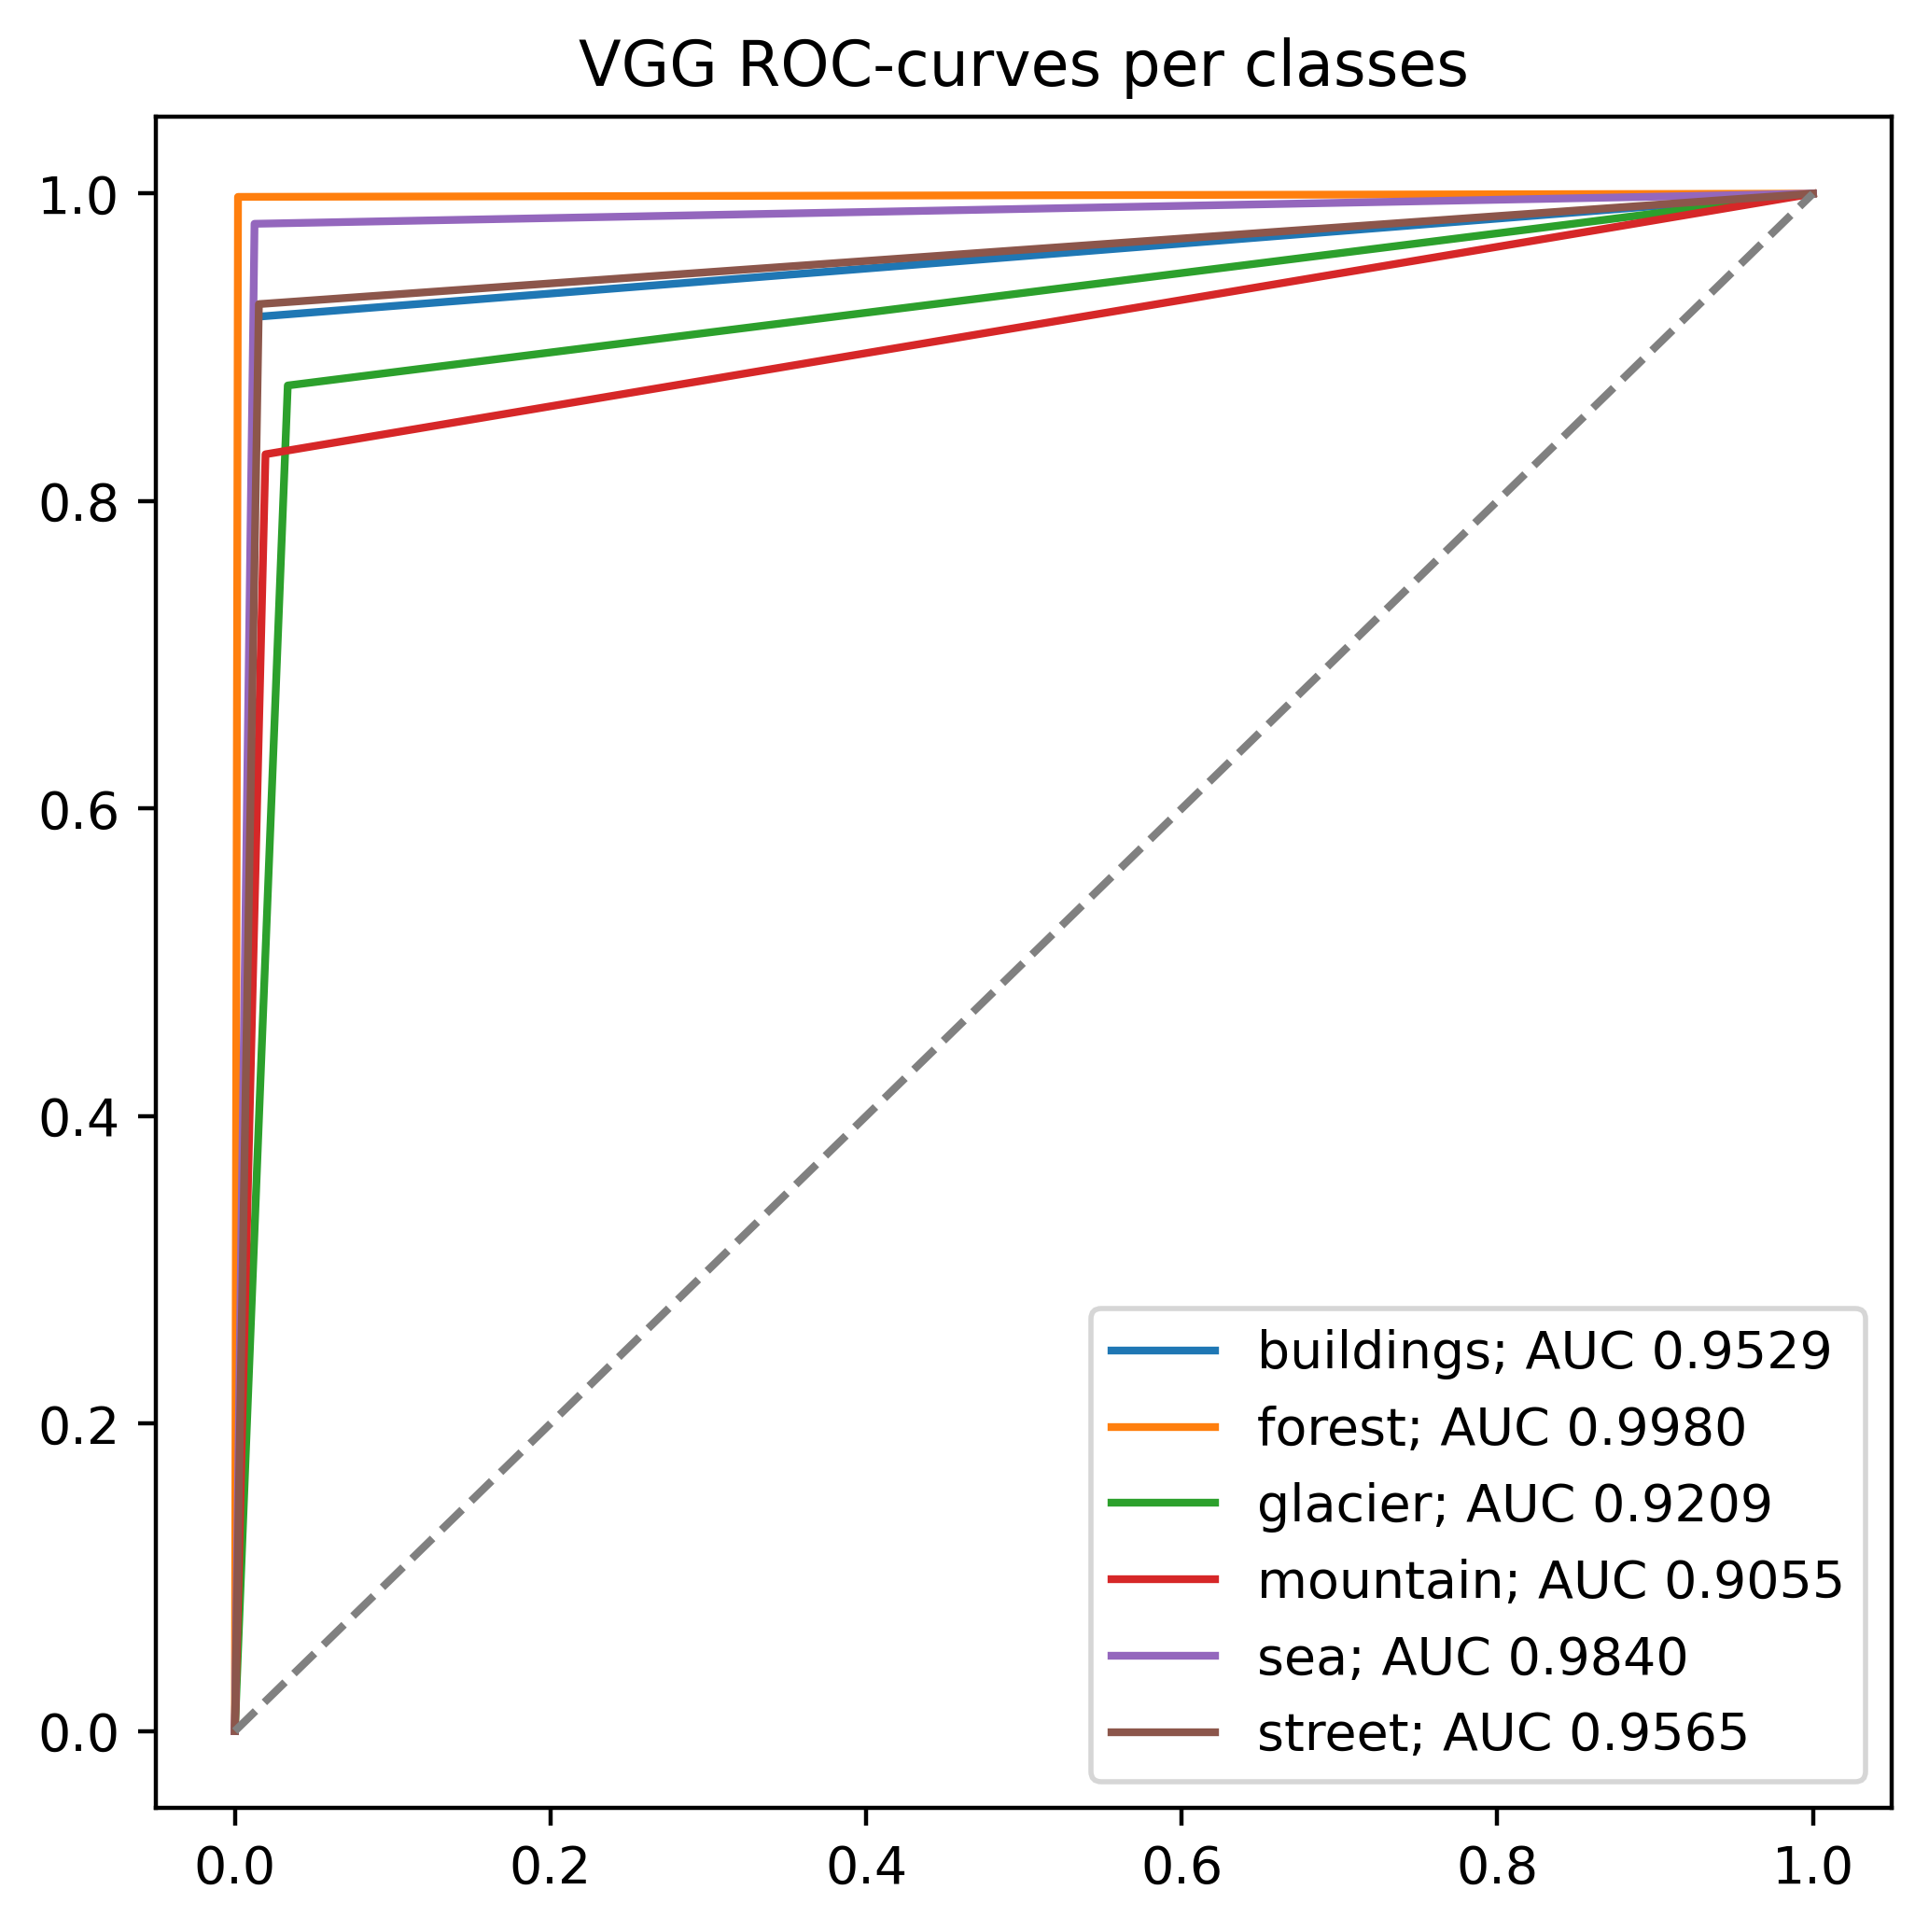

In [83]:
labels_plot = [(labels.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]
fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]
fig = plt.figure(figsize=(6,6), dpi=400)
plt.title('VGG ROC-curves per classes')

for i in range(6):
  plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label = (class_names[i] + "; AUC " + "%.4f" % (roc_auc[i])))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "grey")
plt.show()

Classification Report for MobileNet

In [85]:
_, outs = torch.max(outputs_1, dim=1)
print(classification_report(labels_1.cpu().numpy(), outs.cpu().numpy(), target_names=class_names))

              precision    recall  f1-score   support

   buildings       0.87      0.94      0.90       437
      forest       1.00      0.99      0.99       474
     glacier       0.84      0.88      0.86       553
    mountain       0.89      0.81      0.85       525
         sea       0.93      0.97      0.95       510
      street       0.95      0.88      0.91       501

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000



Confusion matrix for MobileNEt

In [86]:
print (confusion_matrix(labels_1.cpu().numpy(), outs.cpu().numpy(), normalize='true'))

[[0.94279176 0.         0.00228833 0.00228833 0.00457666 0.04805492]
 [0.         0.98945148 0.00421941 0.00421941 0.0021097  0.        ]
 [0.00723327 0.         0.88065099 0.07775769 0.03074141 0.00361664]
 [0.00380952 0.00190476 0.15428571 0.80571429 0.03428571 0.        ]
 [0.00392157 0.         0.01960784 0.00588235 0.97058824 0.        ]
 [0.10978044 0.         0.00399202 0.00399202 0.00399202 0.87824351]]


ROC-curves

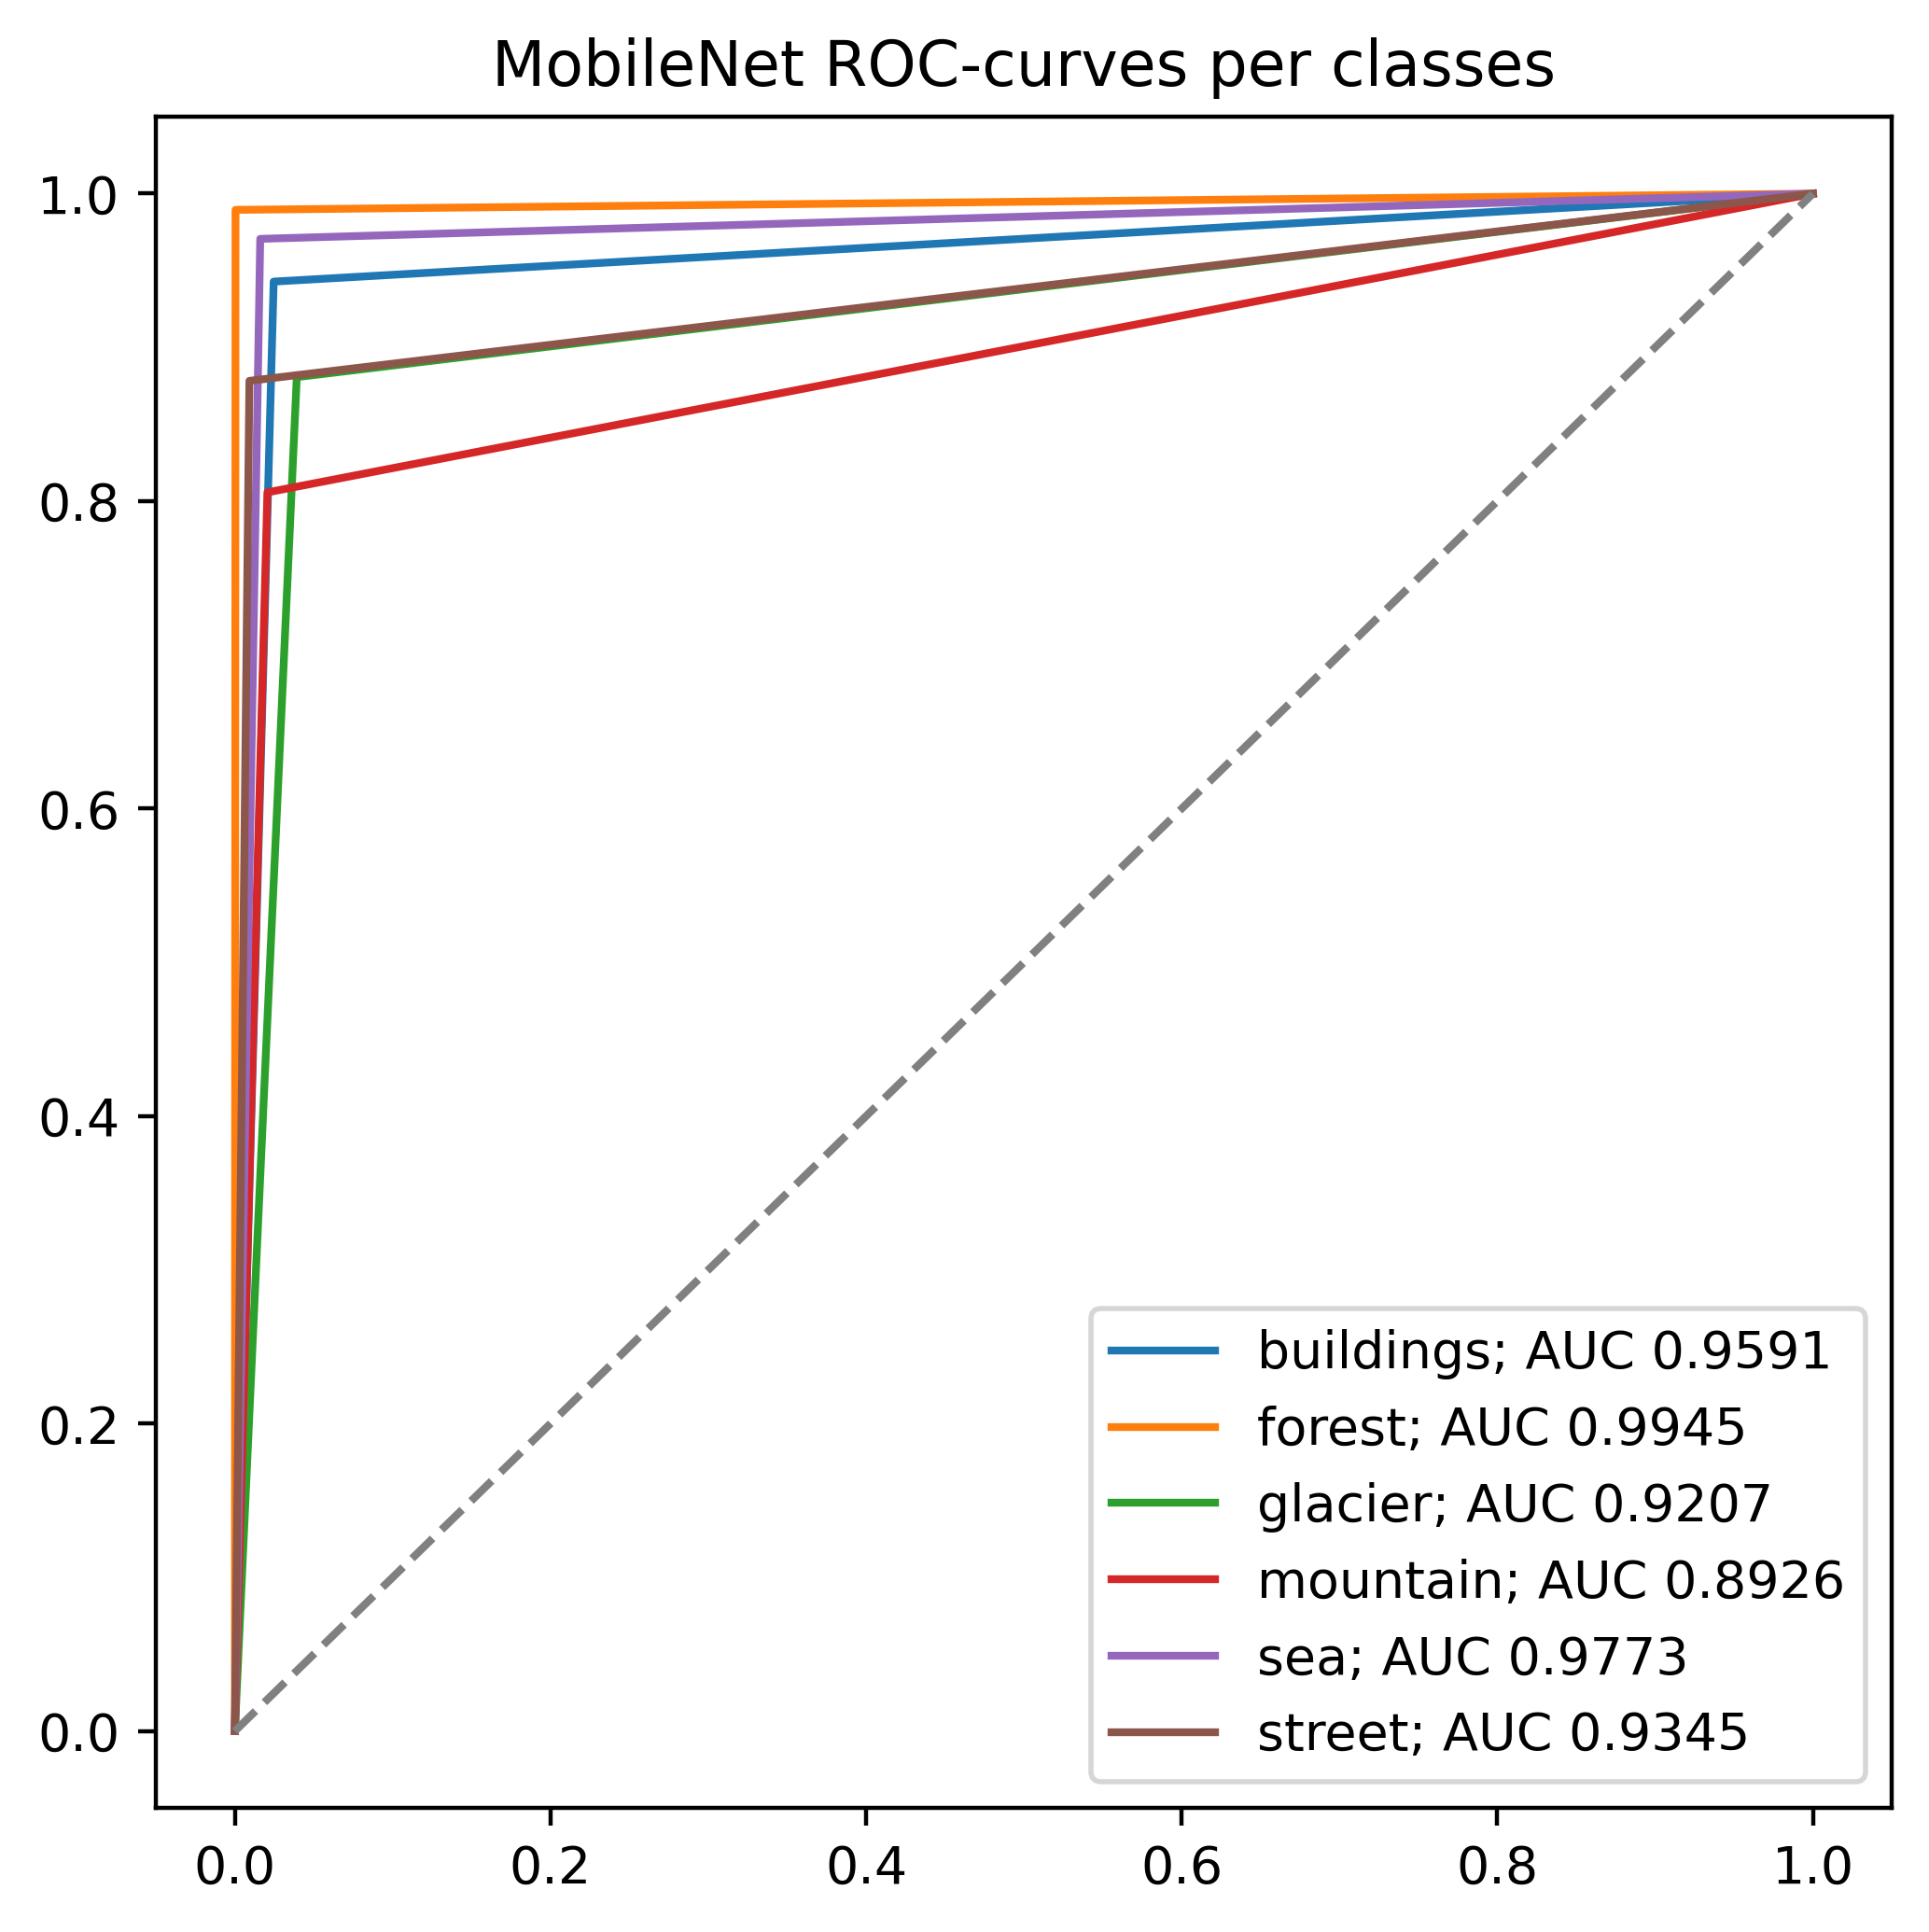

In [87]:
labels_plot = [(labels_1.cpu().numpy() == i).astype(float) for i in range(6)]
outs_plot = [(outs.cpu().numpy() == i).astype(float) for i in range(6)]
fpr_tpr = [roc_curve(labels_plot[i], outs_plot[i]) for i in range(6)]
roc_auc = [auc(fpr_tpr[i][0], fpr_tpr[i][1]) for i in range(6)]
fig = plt.figure(figsize=(6,6), dpi=400)
plt.title('MobileNet ROC-curves per classes')

for i in range(6):
  plt.plot(fpr_tpr[i][0], fpr_tpr[i][1], label = (class_names[i] + "; AUC " + "%.4f" % (roc_auc[i])))
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'--', color = "grey")
plt.show()

MobileNet visualisation

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


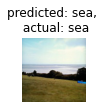

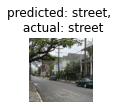

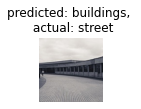

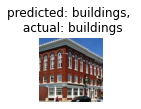

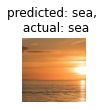

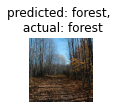

In [92]:
def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)

def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['test']):
            inputs = inputs.to("cuda:0")
            labels = labels.to("cuda:0")

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}, \n actual: {}'.format(class_names[preds[j]], class_names[labels[j]]))

                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

visualize_model(trained_mob[0], num_images=6)

VGG visualisation

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 8 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


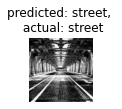

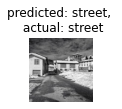

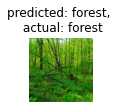

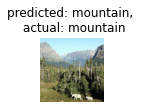

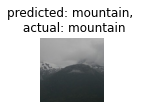

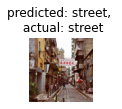

In [93]:
visualize_model(trained_vgg_model, num_images=6)